# Predicting Casualties from Tornado Data (Group 1)

**Authors**: Erika Delorme, Marcela Flaherty, Riddha Tuladhar, Edwin Yeung

# Summary

# Introduction

# Methods & Results

## Data wrangling and cleaning

1. First, we load the necessary packages. 

In [1]:
library(repr)
library(tidyverse)
library(tidymodels)
library(readr)
library(psych)
library(GGally)
# #library(renv)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────────────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5      ✔ rsample      1.2.0 
✔ dials        1.2.1      ✔ tune         1.1.2 
✔ infer        1.0.6      ✔ workflows    1.1.4 
✔ modeldata    1.3.0      ✔ workflowsets 1.0.1 
✔ parsnip      1.2.0      ✔ yardstick    1.3.0 
✔ recipes      1.0.10     

── Con

2. Then, we read in the data about tornadoes directly from the website. 

In [2]:
# Load data
URL <- "https://raw.githubusercontent.com/rfordatascience/tidytuesday/a9e277dd77331e9091e151bb5adb584742064b3e/data/2023/2023-05-16/tornados.csv"
tornado_data <- read.csv(URL)

head(tornado_data)

,om,yr,mo,dy,date,time,tz,datetime_utc,st,stf,⋯,elon,len,wid,ns,sn,f1,f2,f3,f4,fc
,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,⋯,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<lgl>
1,192,1950,10,1,1950-10-01,21:00:00,America/Chicago,1950-10-02T03:00:00Z,OK,40,⋯,-102.30,15.8,10,1,1,25,0,0,0,FALSE
2,193,1950,10,9,1950-10-09,02:15:00,America/Chicago,1950-10-09T08:15:00Z,NC,37,⋯,0.00,2.0,880,1,1,47,0,0,0,FALSE
3,195,1950,11,20,1950-11-20,02:20:00,America/Chicago,1950-11-20T08:20:00Z,KY,21,⋯,0.00,0.1,10,1,1,177,0,0,0,FALSE
4,196,1950,11,20,1950-11-20,04:00:00,America/Chicago,1950-11-20T10:00:00Z,KY,21,⋯,0.00,0.1,10,1,1,209,0,0,0,FALSE
5,197,1950,11,20,1950-11-20,07:30:00,America/Chicago,1950-11-20T13:30:00Z,MS,28,⋯,0.00,2.0,37,1,1,101,0,0,0,FALSE
6,194,1950,11,4,1950-11-04,17:00:00,America/Chicago,1950-11-04T23:00:00Z,PA,42,⋯,-75.93,15.9,100,1,1,71,11,0,0,FALSE


3. Next, we wrangle and clean the data. Firstly, we check for missing values in our cleaned data.

In [3]:
sapply(tornado_data, function(x) sum(is.na(x)))

om           yr           mo           dy         date         time 
           0            0            0            0            0            0 
          tz datetime_utc           st          stf          mag          inj 
           0            0            0            0          756            0 
         fat         loss         slat         slon         elat         elon 
           0        27170            0            0            0            0 
         len          wid           ns           sn           f1           f2 
           0            0            0            0            0            0 
          f3           f4           fc 
           0            0            0

We can see that there are no missing values, except for the feature `loss`, with 27,170 missing values. The feature `loss` refers to the financial loss of each tornado. For our regression problem, we did not deem this feature to be an important feature. Therefore, we decide to remove this column. 

There are also 756 missing values for the feature `mag`. Because there are not so many rows missing, we decide to filter those rows out. 

4. Then, we remove irrelevant or repetitive columns and then filter for missing values of the column `mag`, which stands for magnitude. Then, we change the feature names to make them more descriptive. We show the top 6 rows of our cleaned data. 

In [4]:
# Wrangle and clean data

# Remove irrelevant or repetitive columns, and filter for NA in magnitude
df <- tornado_data %>%
    select(-date, -tz, -stf, -sn, -f1, -f2, -f3, -f4, -fc, -loss) %>%
    filter(!is.na(mag)) 

# Change feature names to be more descriptive
names(df) <- c('ID','year','month','day','time','datetime_utc','state','mag','injuries',
               'fatalities','start_lat','start_lon','end_lat','end_lon','length','width','ns')

head(df)

,ID,year,month,day,time,datetime_utc,state,mag,injuries,fatalities,start_lat,start_lon,end_lat,end_lon,length,width,ns
,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
1,192,1950,10,1,21:00:00,1950-10-02T03:00:00Z,OK,1,0,0,36.73,-102.52,36.88,-102.30,15.8,10,1
2,193,1950,10,9,02:15:00,1950-10-09T08:15:00Z,NC,3,3,0,34.17,-78.60,0.00,0.00,2.0,880,1
3,195,1950,11,20,02:20:00,1950-11-20T08:20:00Z,KY,2,0,0,37.37,-87.20,0.00,0.00,0.1,10,1
4,196,1950,11,20,04:00:00,1950-11-20T10:00:00Z,KY,1,0,0,38.20,-84.50,0.00,0.00,0.1,10,1
5,197,1950,11,20,07:30:00,1950-11-20T13:30:00Z,MS,1,3,0,32.42,-89.13,0.00,0.00,2.0,37,1
6,194,1950,11,4,17:00:00,1950-11-04T23:00:00Z,PA,3,1,0,40.20,-76.12,40.40,-75.93,15.9,100,1


In [5]:
# This is to export cleaned data frame to new csv file
#write_csv(df, "C:\\Users\\Erika\\DSCI-310-Group-1-Predict-Casualties-From-Tornado-Data\\data\\processed\\cleaned_tornado_data.csv")

## EDA: Descriptive statistics and visualizations

5. Next, we create a summary table of features that could be useful to use in our regression model. 

In [6]:
describe(df[, c('mag', 'injuries', 'fatalities', 'start_lat', 'start_lon', 'end_lat', 'end_lon', 
                'length', 'width', 'ns')], fast = TRUE)

,vars,n,mean,sd,min,max,range,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mag,1,67937,0.77872146,0.89578979,0.0000,5.0000,5.0000,0.0034367894
injuries,2,67937,1.43447606,18.21464265,0.0000,1740.0000,1740.0000,0.0698823454
fatalities,3,67937,0.09030425,1.48025841,0.0000,158.0000,158.0000,0.0056791633
start_lat,4,67937,37.12084145,5.10796577,17.7212,61.0200,43.2988,0.0195972348
start_lon,5,67937,-92.70567031,8.67919628,-163.5300,-64.7151,98.8149,0.0332986271
end_lat,6,67937,22.79438471,18.55826645,0.0000,61.0200,61.0200,0.0712006934
end_lon,7,67937,-56.38062159,45.38037316,-163.5300,0.0000,163.5300,0.1741064579
length,8,67937,3.51464195,8.28672352,0.0000,234.7000,234.7000,0.0317928651
width,9,67937,108.42309787,207.81143767,0.0000,4576.0000,4576.0000,0.7972899033


6. We create a correlation matrix to view the correlations between features related to `injuries` and `fatalities`. 

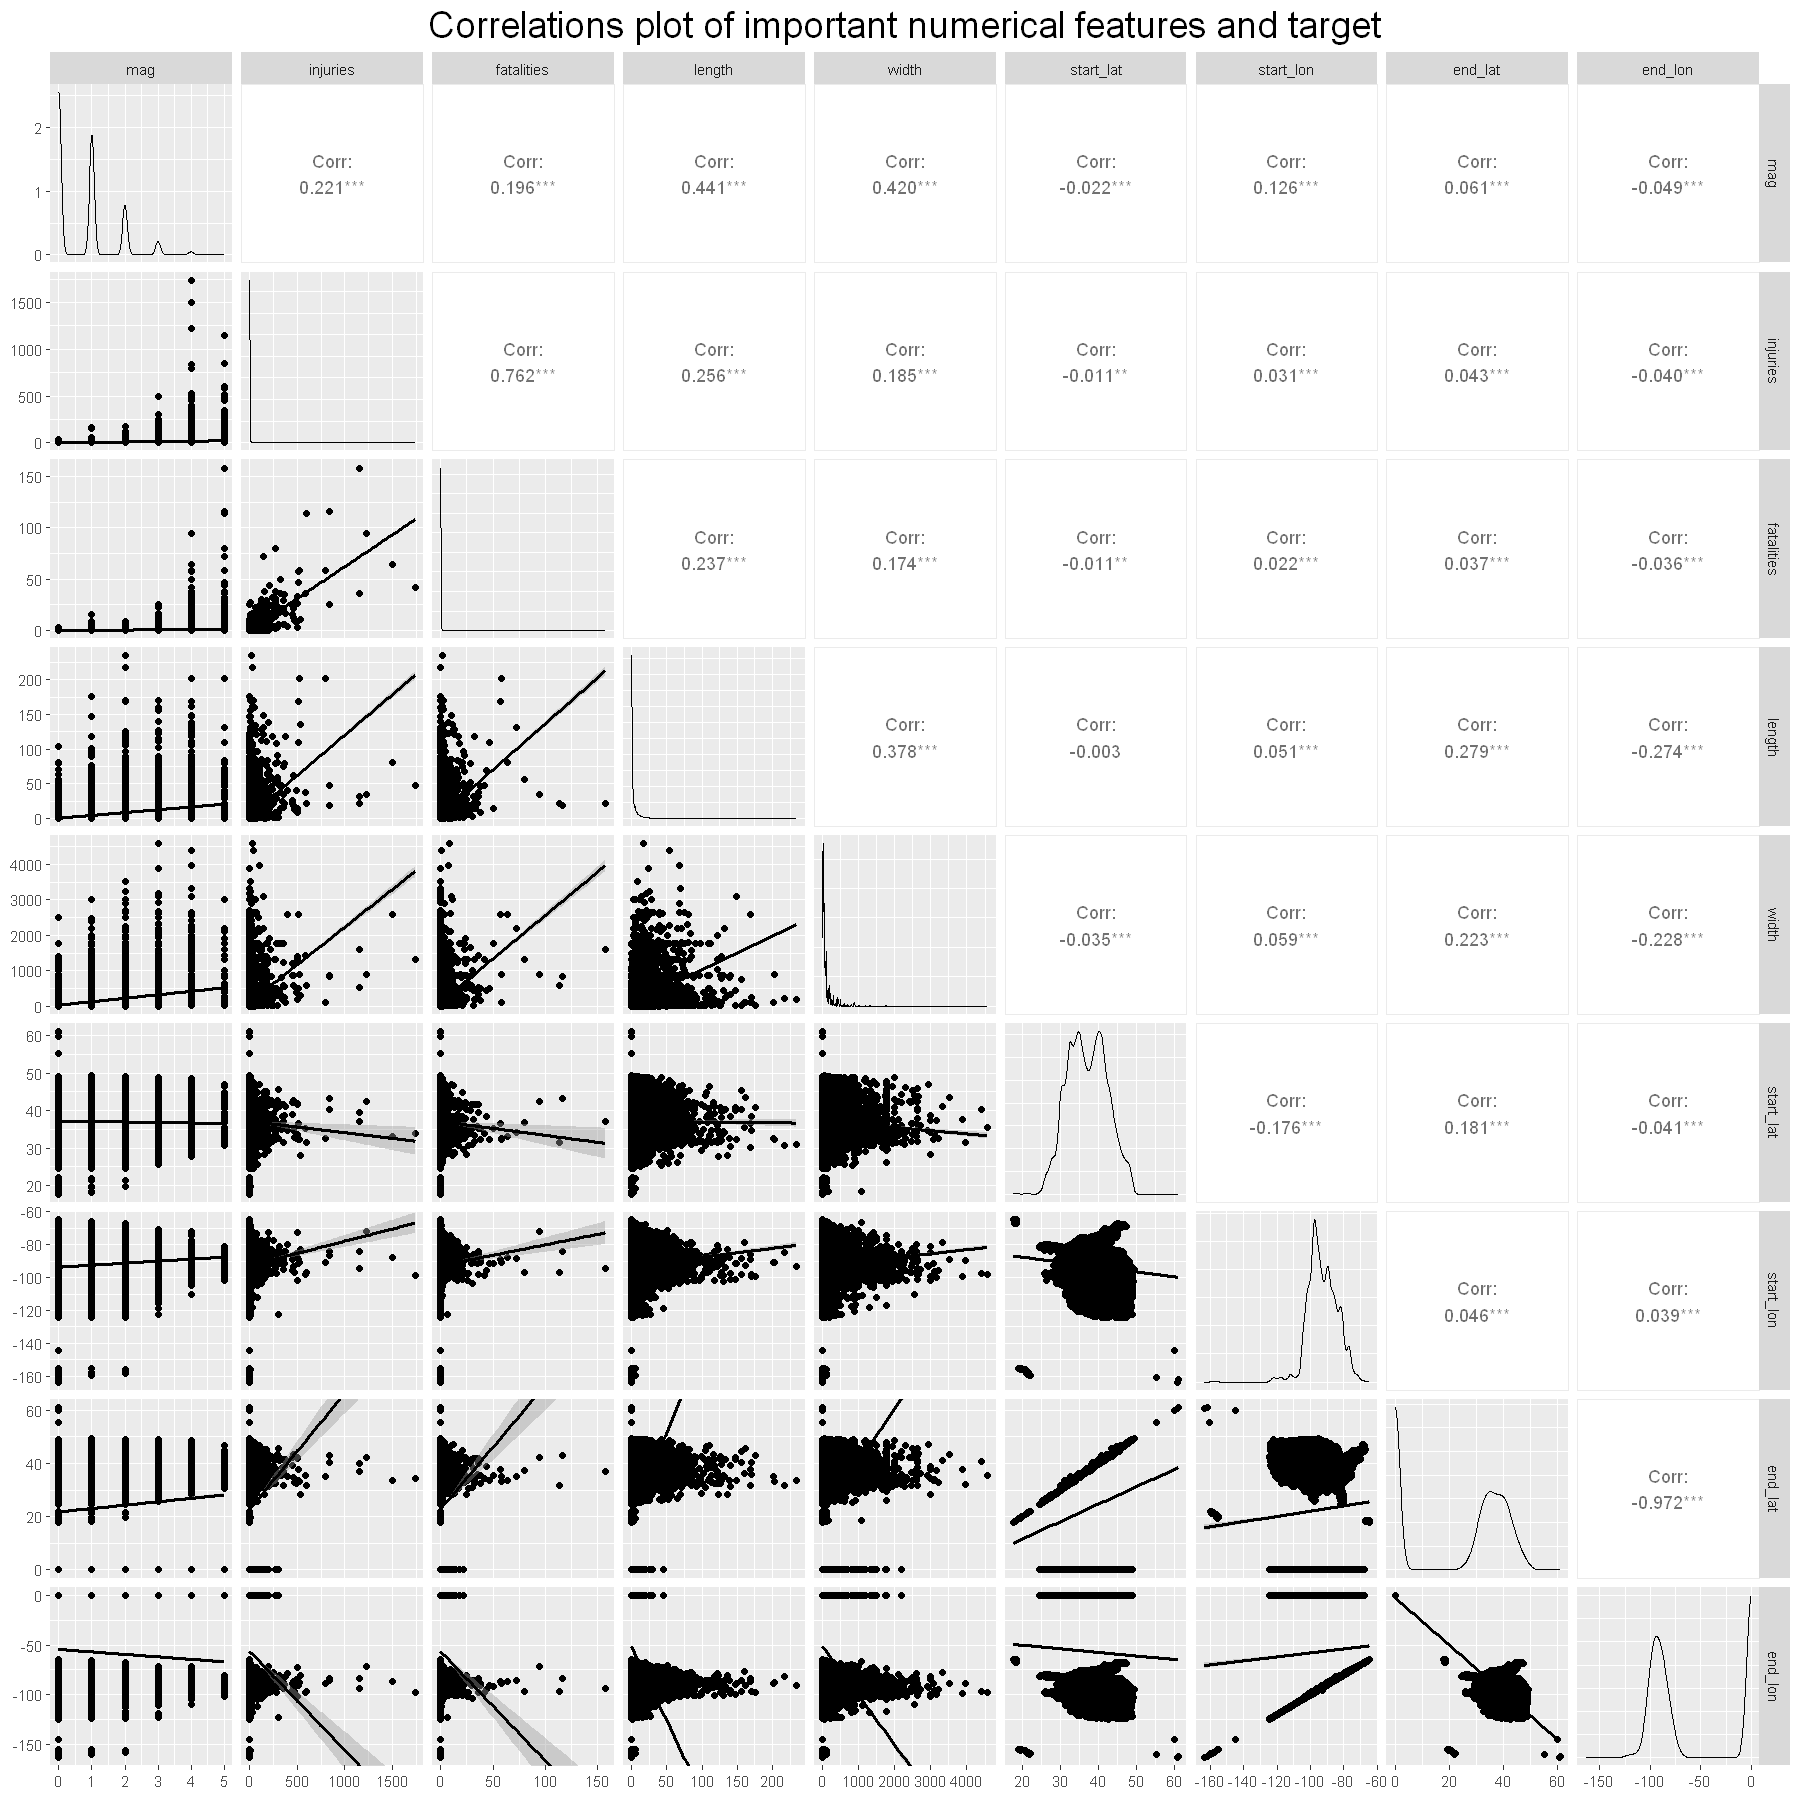

In [7]:
options(repr.plot.width = 15, repr.plot.height = 15)

correlations_plot <- df %>%
    ggpairs(
        columns = c("mag", "injuries", "fatalities", "length", "width", "start_lat", "start_lon", 
                    "end_lat", "end_lon"), 
        lower = list(
            continuous = "smooth", 
            combo = wrap("facethist", binwidth = 2)),
            title = "Correlations plot of important numerical features and target") +
    theme(plot.title = element_text(size = 22, hjust = 0.5))
correlations_plot

From the correlation matrix, we observe that there are some small sized correlations between `injuries` and `fatalities` and other continuous features. For example, there is a correlation of `0.224` between `injuries` and `mag`. Two other correlations that may be worthy to note are: correlation of `0.259` between `length` and `injuries` and a correlation of `0.239` between `length` and `fatalities`. 

There are also correlations between features that are not the target. For example, there is medium sized correlation of `0.444` between `length` and `mag` and a correlation of `0.417` between `width` and `mag`.

These small to medium correlations may suggest that these features could be useful in predicting `fatalities` and `injuries`. 

The correlation between `fatalities` and `injuries` is also pretty high with a correlation of `0.765`, which is sort of expected as these targets are both related to casualties. 

## Model selection and analysis

7. We split our data into two sets: `train_df` and `test_df`. `train_df` consists of 75% of our original data set and is used to train our regression model. The remaining 25% of our original data is `test_df`, which we use later to test the accuracy of our model at prediction. 

In [8]:
set.seed(2000)

data_split <- initial_split(df, prop = 0.75, strata = fatalities)
train_df <- training(data_split)
test_df <- testing(data_split)

8. As mentioned previously, our group has decided that we will use a linear regression model to predict tornado casualties. We will be using the variables `width` and `length` as our predictors. The former is a measure of the width of a tornado, while the latter is a measure of length. The units of measurements are yards and miles, respectively.

   Now that we have our training data `train_df`, we can fit our linear regression model. We will first specify our model, and then proceed to fit our model and obtain the regression coefficients.

In [9]:
# specify prediction model
lm_spec <- linear_reg() |>
  set_engine("lm") |>
  set_mode("regression")

# specify recipe
lm_recipe <- recipe(fatalities ~ length + width, data = df)

# fit the model based on the recipe, specification and training data
lm_fit <- workflow() |>
  add_recipe(lm_recipe) |>
  add_model(lm_spec) |>
  fit(data = train_df)

lm_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)       length        width  
 -0.1183680    0.0367960    0.0007337  


9. Now that we have our model, we can predict on the testing data `test_df` to assess how well it does.

In [10]:
# Use lm_fit to predict on test_df and output RMSPE to assess model's test error
lm_test_results <- lm_fit |>
  predict(test_df) |>
  bind_cols(test_df) |>
  metrics(truth = fatalities, estimate = .pred)

lm_test_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1.00567700
rsq,standard,0.08983574
mae,standard,0.22985357


We can visualize our linear regression model to get a better idea of how well it performs.

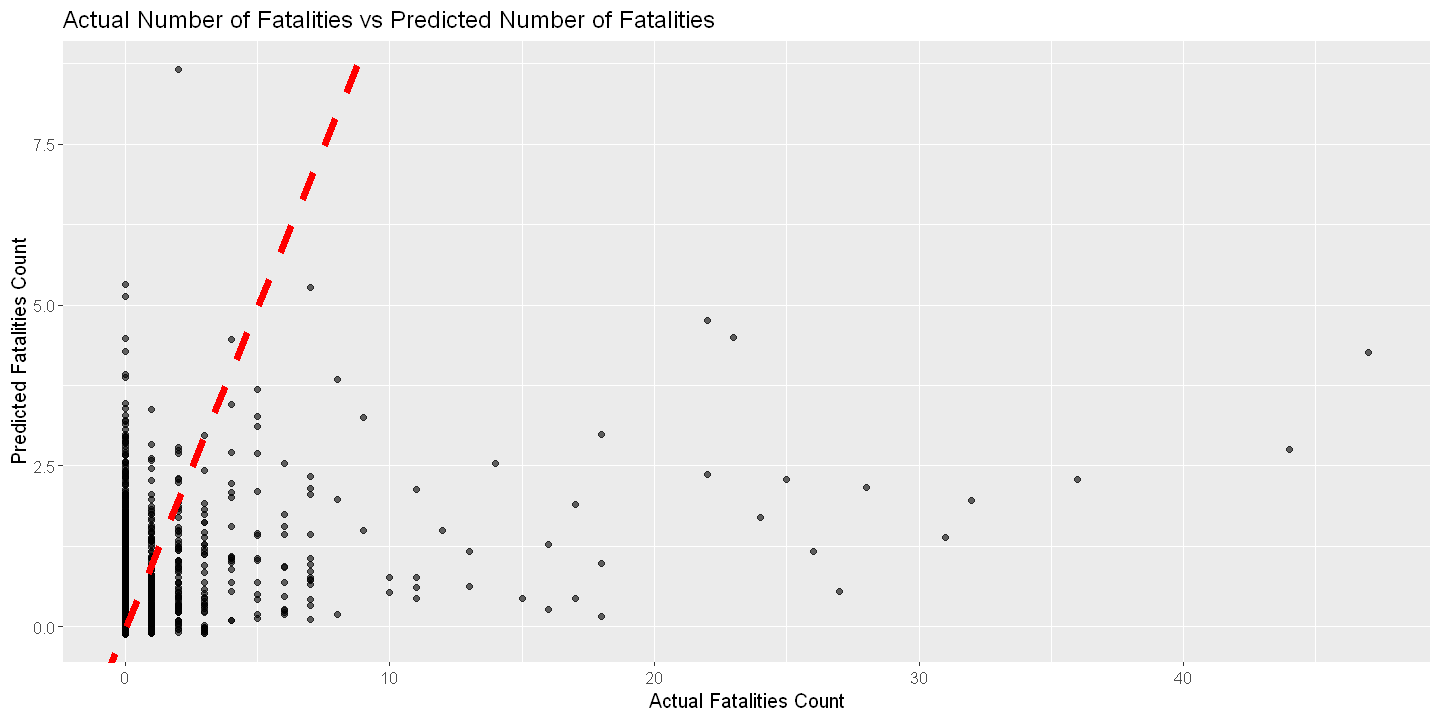

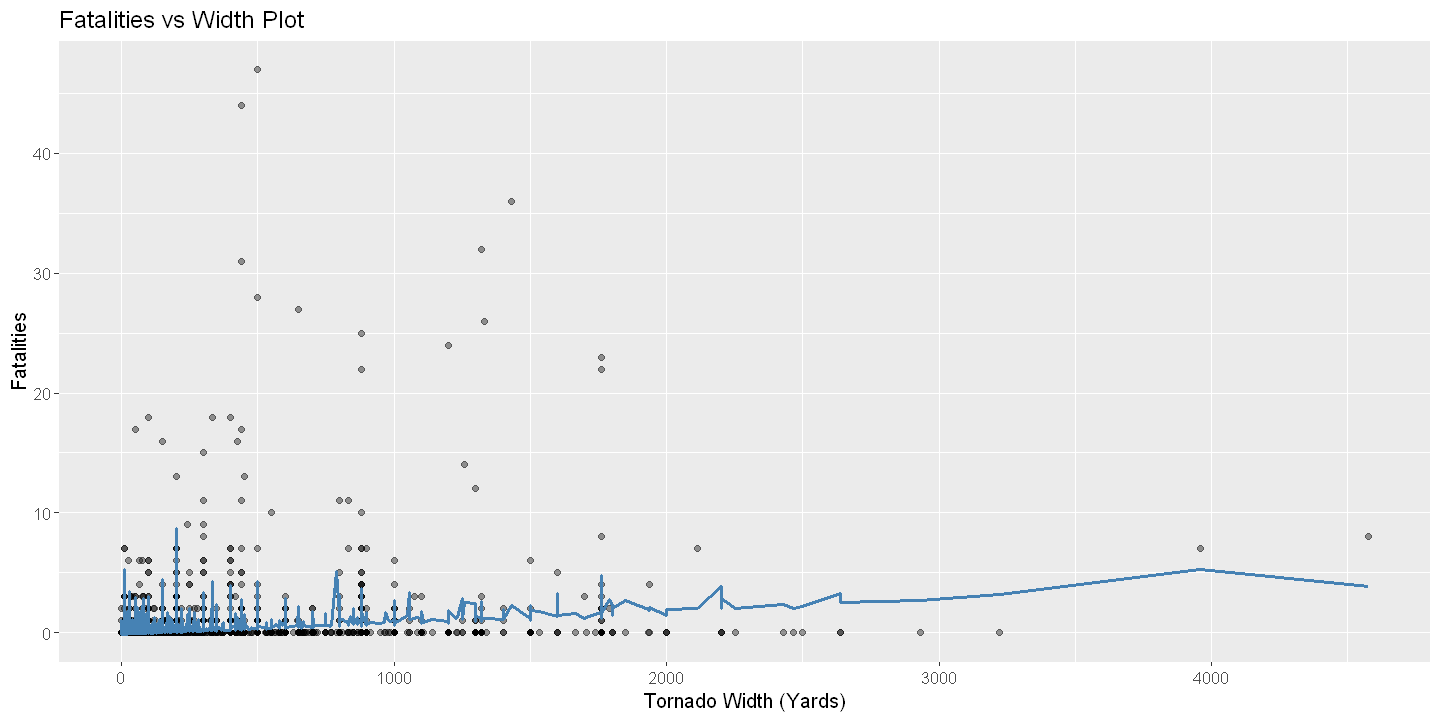

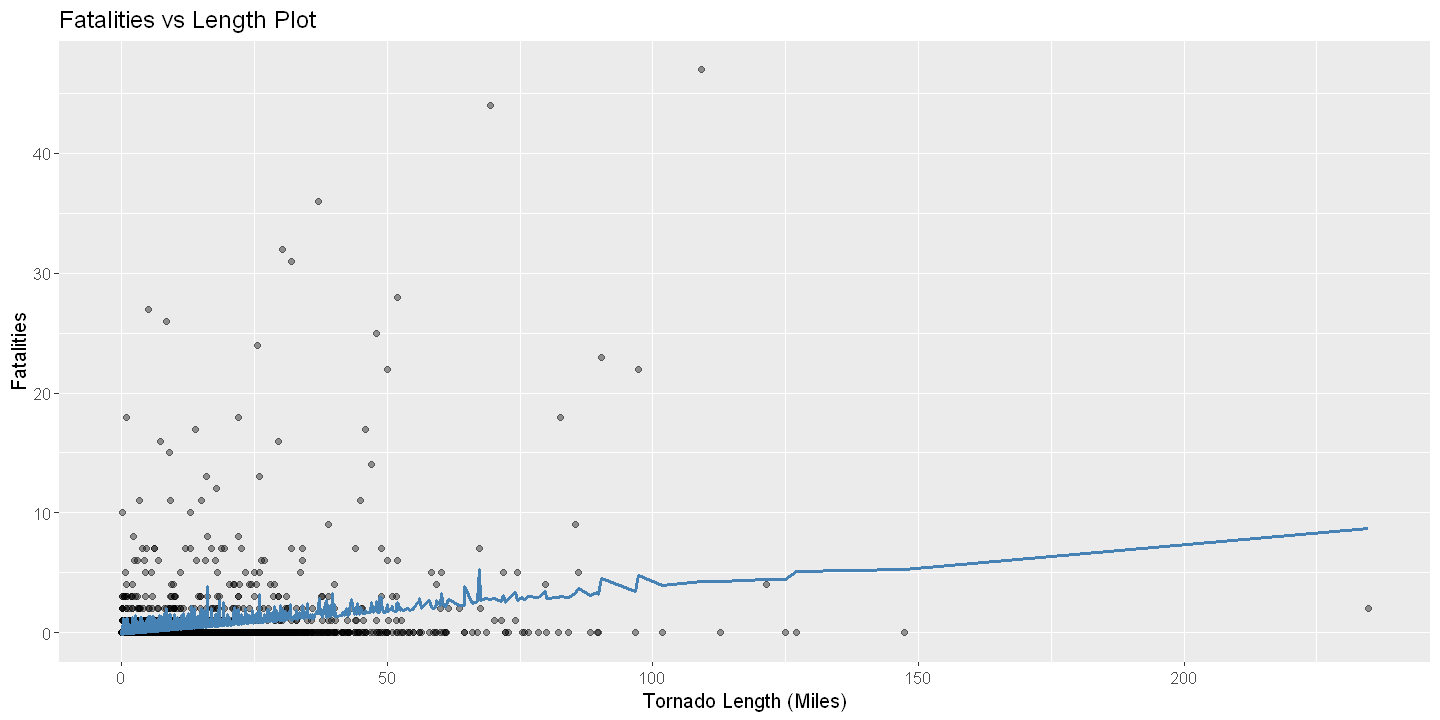

In [34]:
####################### some scaffolding i pasted from DSCI 100 textbook to help :)

#sqft_prediction_grid <- tibble(
#    sqft = c(
#        sacramento |> select(sqft) |> min(),
#        sacramento |> select(sqft) |> max()
#    )
#)

#sacr_preds <- lm_fit |>
#  predict(sqft_prediction_grid) |>
#  bind_cols(sqft_prediction_grid)

#lm_plot_final <- ggplot(sacramento, aes(x = sqft, y = price)) +
#  geom_point(alpha = 0.4) +
#  geom_line(data = sacr_preds,
#            mapping = aes(x = sqft, y = .pred),
#            color = "steelblue",
#            linewidth = 1) +
#  xlab("House size (square feet)") +
#  ylab("Price (USD)") +
#  scale_y_continuous(labels = dollar_format()) +
#  theme(text = element_text(size = 12))

#lm_plot_final


# options(repr.plot.width = 12, repr.plot.height = 6)
# aqi_predictions <- aqi_fit |>
#     predict(aqd_test) |>
#     bind_cols(aqd_test)
# model_viz <- ggplot(aqi_predictions, aes(x = .pred, y = aqi))+
#     geom_point(alpha = 0.6)+
#     geom_abline(intercept = 0, slope = 1, color = "red", linetype = "dashed", linewidth = 2)+
#     labs(title = "Actual vs Predicted AQI values (Figure 7)", x = "Predicted AQI", y = "Observed AQI")+
#     theme(text = element_text(size = 20))
# model_viz

fatal_rsmpe <- lm_test_results |>
    filter(.metric == "rmse") |>
    select(.estimate) |>
    pull()

fatal_predictions <- lm_fit |>
    predict(test_df) |>
    bind_cols(test_df)

options(repr.plot.width = 12, repr.plot.height = 6)

## Note: Red line represents where points would be plotted if the model was 100% accurate
fatal_model_viz <- ggplot(fatal_predictions, aes(x = fatalities, y = .pred)) +
    geom_point(alpha = 0.6) +
    # geom_line(data = fatal_predictions,
    #        mapping = aes(x = fatalities, y = .pred),
    #        color = "steelblue",
    #        linewidth = 1) +
    geom_abline(intercept = 0, slope = 1, color = "red", linetype = "dashed", linewidth = 2)+
    xlab("Actual Fatalities Count") +
    ylab("Predicted Fatalities Count") +
    ggtitle("Actual Number of Fatalities vs Predicted Number of Fatalities") +
    theme(text = element_text(size = 12))

fatal_model_viz

## Note: Blue line represents predicted values based on our regression model
fatal_widths_plot <- ggplot(test_df, aes(x = width, y = fatalities)) +
     geom_point(alpha = 0.4) +
     geom_line(data = fatal_predictions,
           mapping = aes(x = width, y = .pred),
           color = "steelblue",
           linewidth = 1) +
     xlab("Tornado Width (Yards)") +
     ylab("Fatalities") +
     ggtitle("Fatalities vs Width Plot") +
     theme(text = element_text(size = 12))

fatal_widths_plot

## Note: Blue line represents predicted values based on our regression model
fatal_length_plot <- ggplot(test_df, aes(x = length, y = fatalities)) +
     geom_point(alpha = 0.4) +
     geom_line(data = fatal_predictions,
           mapping = aes(x = length, y = .pred),
           color = "steelblue",
           linewidth = 1) +
     xlab("Tornado Length (Miles)") +
     ylab("Fatalities") +
     ggtitle("Fatalities vs Length Plot") +
     theme(text = element_text(size = 12))

fatal_length_plot

# Discussion

# References